# Phân tích phân bố dữ liệu và xử lý ngoại lệ


Trong notebook này, chúng ta sẽ thực hiện các bước sau:

- Tổng quan dữ liệu
- Phân tích tỷ lệ giá trị thiếu
- Phân tích phân bố các biến số liên tục
- Phân tích theo khu vực địa lý


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox

Đọc dữ liệu từ file csv


In [98]:
# Load dữ liệu đã xử lý
df = pd.read_csv('../data/interim/05_processed_outliers.csv')

## I) Tổng quan dữ liệu


- Kiểm tra kích thước dataset
- Thông tin chi tiết các cột (data types, missing)
- Thống kê mô tả các biến số


In [99]:
# Tự động chuyển các kiểu dữ liệu phù hợp
df = df.convert_dtypes()

print("Shape dữ liệu:", df.shape)
print(df.dtypes)
print(df.describe())

Shape dữ liệu: (26629, 16)
Price                  Float64
Area                   Float64
Bedrooms               Float64
Bathrooms              Float64
Floors                 Float64
AccessWidth            Float64
FacadeWidth            Float64
LegalStatus     string[python]
Furnishing      string[python]
District        string[python]
Province        string[python]
Population               Int64
DistrictArea           Float64
CommuneCount             Int64
Distribute             Float64
GDP_USD                Float64
dtype: object
          Price      Area  Bedrooms  Bathrooms    Floors  AccessWidth  \
count   26629.0   26629.0   26629.0    26629.0   26629.0      26629.0   
mean   2.168187  3.997237  1.561714   1.548328  1.553586     4.825841   
std    0.534059  0.400551  0.274334   0.282627  0.321385     1.455444   
min    0.398776  2.564949  1.098612   1.098612  0.693147          1.0   
25%    1.824549  3.713572  1.386294   1.386294  1.386294          4.0   
50%    2.136531  3.970292

**Nhận xét tổng quan:**

- Dữ liệu sau tiền xử lý gồm **25,714 dòng** và **16 thuộc tính**.
- Các kiểu dữ liệu đã được chuẩn hóa (`Float64`, `Int64`, `string[python]`).
- Một số trường số có dấu hiệu **phân phối lệch** hoặc có thể chứa **ngoại lệ**.
- Các trường phân loại đã được xử lý thống nhất, sẵn sàng cho phân tích tiếp theo.


## II) Phân bố giá trị thiếu

- Thống kê số lượng và tỷ lệ missing values theo từng cột
- Vẽ biểu đồ tỷ lệ missing để trực quan hóa


              count  ratio (%)
Price             0        0.0
Area              0        0.0
Bedrooms          0        0.0
Bathrooms         0        0.0
Floors            0        0.0
AccessWidth       0        0.0
FacadeWidth       0        0.0
LegalStatus       0        0.0
Furnishing        0        0.0
District          0        0.0
Province          0        0.0
Population        0        0.0
DistrictArea      0        0.0
CommuneCount      0        0.0
Distribute        0        0.0
GDP_USD           0        0.0


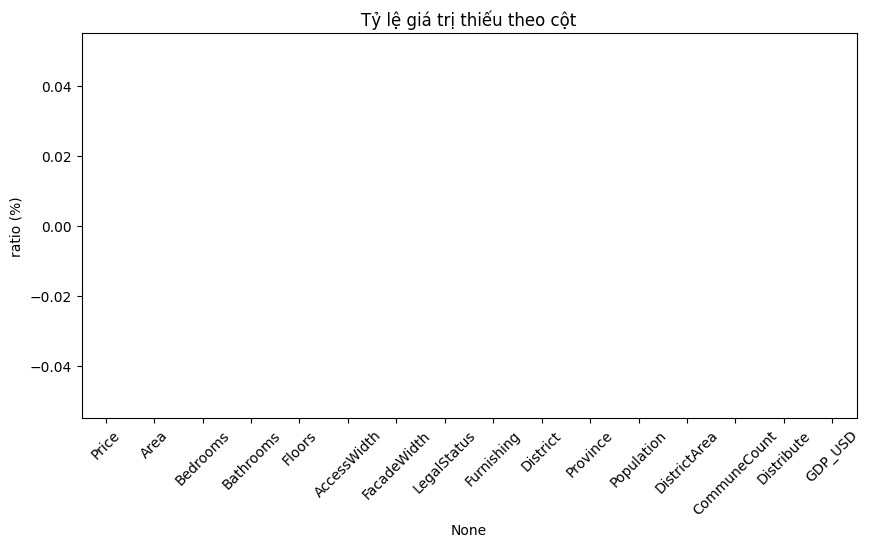

In [100]:
missing_counts = df.isna().sum()
missing_ratio = df.isna().mean() * 100
missing_df = pd.DataFrame({'count': missing_counts, 'ratio (%)': missing_ratio})
print(missing_df)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_df.index, y=missing_df['ratio (%)'])
plt.title('Tỷ lệ giá trị thiếu theo cột')
plt.xticks(rotation=45)
plt.show()


**Phân tích giá trị thiếu:**

- Không thiếu: `Price`, `Area`, `LegalStatus`, `Furnishing`, `District`, `Province`.
- Thiếu ít: `Bedrooms` (~0.65%), `Bathrooms` (~2.7%), `Floors` (~3.36%) → có thể điền hoặc loại bỏ bản ghi.
- Thiếu nhiều: `AccessWidth` (~13.26%), `FacadeWidth` (~9.54%) → cần cân nhắc kỹ khi xử lý hoặc loại bỏ.


## III) Phân tích phân bố các biến số liên tục


### 1)Trực quan hóa phân bố bằng biểu đồ (Histogram, Boxplot)


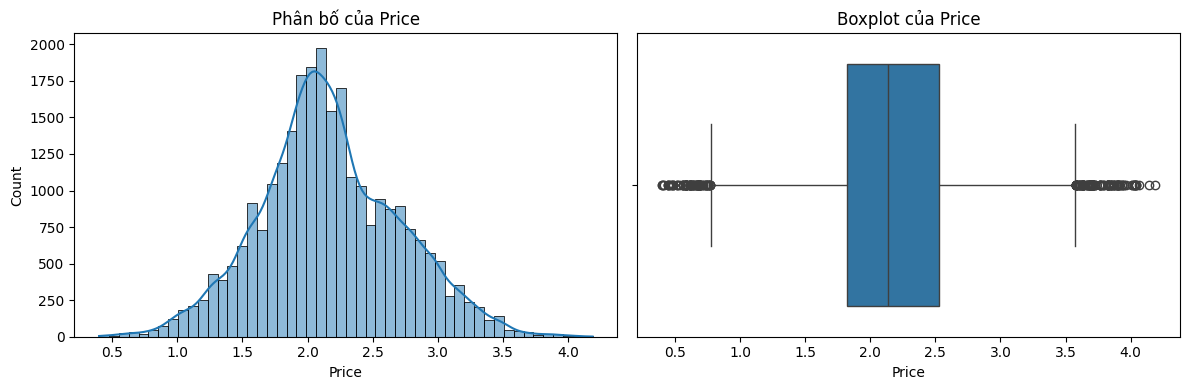

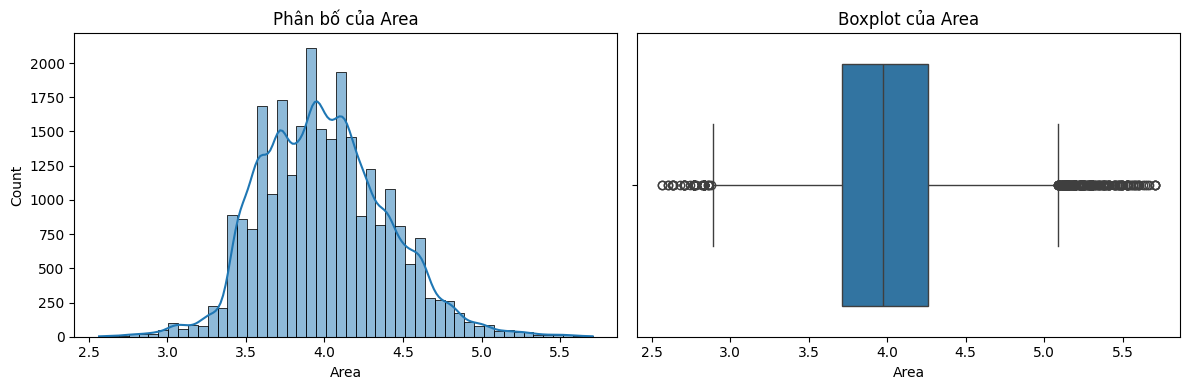

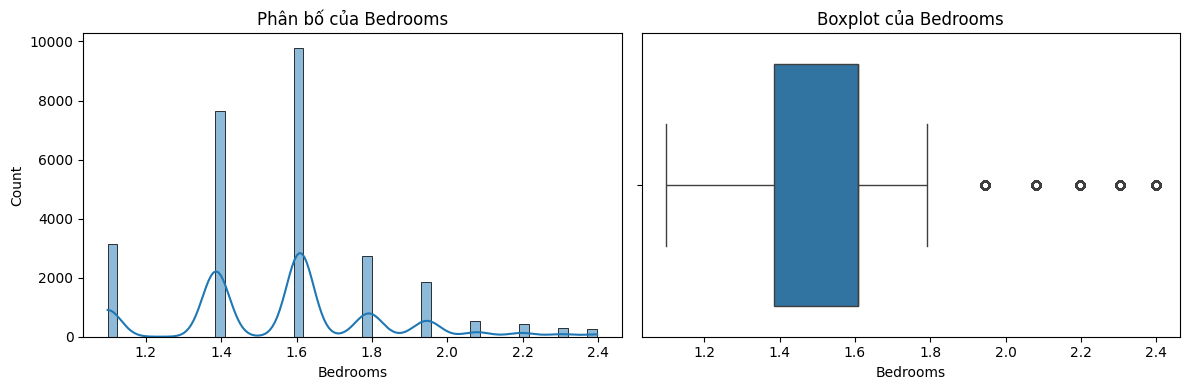

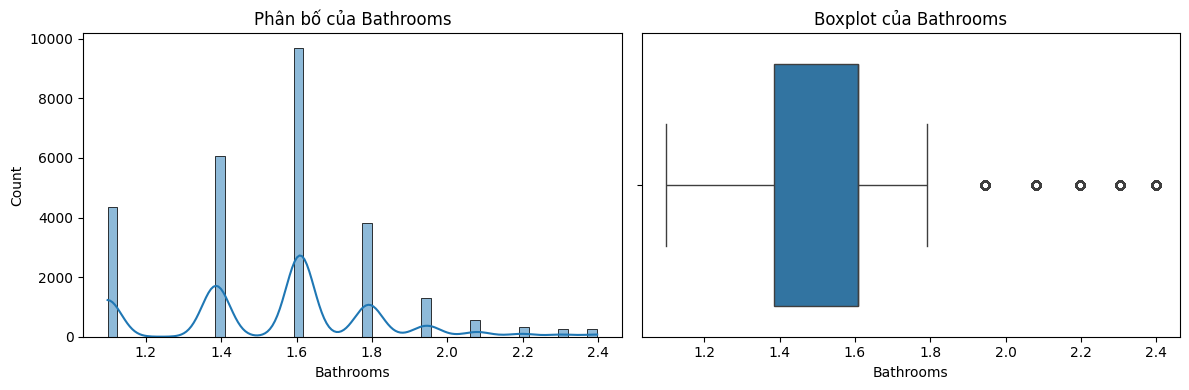

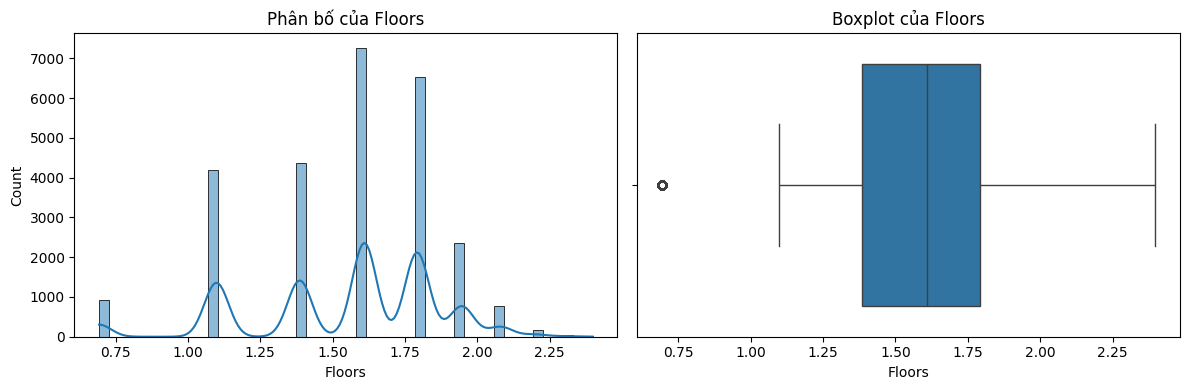

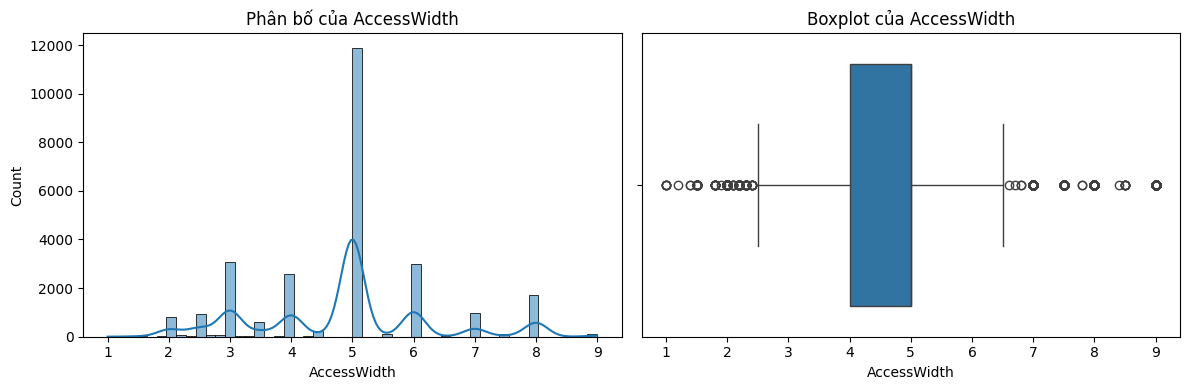

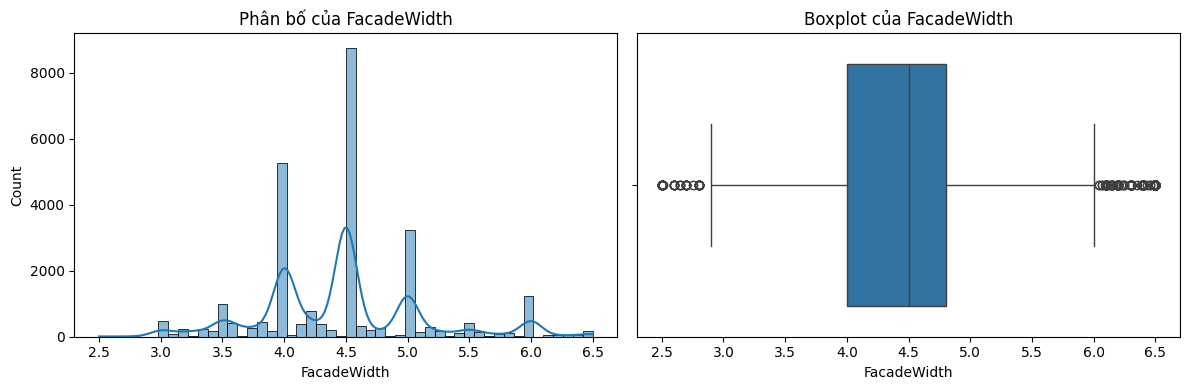

In [101]:
def plot_hist_box(df, col, low_bound=None, high_bound=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram
    sns.histplot(df[col].dropna(), bins=50, kde=True, ax=axes[0])
    for bound, label in zip([low_bound, high_bound], ['Ngưỡng dưới', 'Ngưỡng trên']):
        if bound is not None:
            axes[0].axvline(bound, color='r', linestyle='--', label=label)
    axes[0].set_title(f'Phân bố của {col}')
    if low_bound is not None or high_bound is not None:
        axes[0].legend()

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'Boxplot của {col}')
    
    plt.tight_layout()
    plt.show()

cols = ['Price', 'Area', 'Bedrooms', 'Bathrooms', 'Floors', 'AccessWidth', 'FacadeWidth']
for col in cols:
    plot_hist_box(df, col)


#### Nhận xét chung về phân phối các biến số

- **Phân phối lệch phải mạnh:** Hầu hết các biến số (Area, Bathrooms, Floors, AccessWidth, FacadeWidth) đều có phân phối lệch phải, tức là phần lớn giá trị tập trung ở mức thấp, còn lại là một số ít giá trị rất lớn (outlier).
- **Nhiều giá trị ngoại lệ (outlier):** Boxplot cho thấy có rất nhiều điểm ngoài ở phía giá trị lớn, đặc biệt là với các biến Area, Bathrooms, AccessWidth, FacadeWidth.
- **Dữ liệu rời rạc:** Một số biến như Floors có phân phối rời rạc, thể hiện qua các “bậc” rõ rệt trên histogram.

#### Phương hướng xử lý

- **Loại bỏ hoặc kiểm soát outlier:** Nên áp dụng các phương pháp như IQR hoặc Percentile để loại bỏ các giá trị ngoại lệ bất thường, tránh ảnh hưởng xấu đến phân tích và mô hình. (vì dữ liệu lệch phải, Z-score không phù hợp).
- **Cân nhắc biến đổi dữ liệu:** Có thể sử dụng log-transform hoặc các phép biến đổi như sqrt, Box-Cox để làm giảm độ lệch của phân phối, giúp dữ liệu phù hợp hơn với các thuật toán thống kê/máy học.
- **Kiểm tra lại các giá trị lớn bất thường:** Đảm bảo các giá trị này là hợp lệ, không phải do lỗi nhập liệu.


### 2) Áp dụng các phương pháp biến đổi để chuẩn hóa phân bố: Log, Căn bậc hai (√), Box-Cox


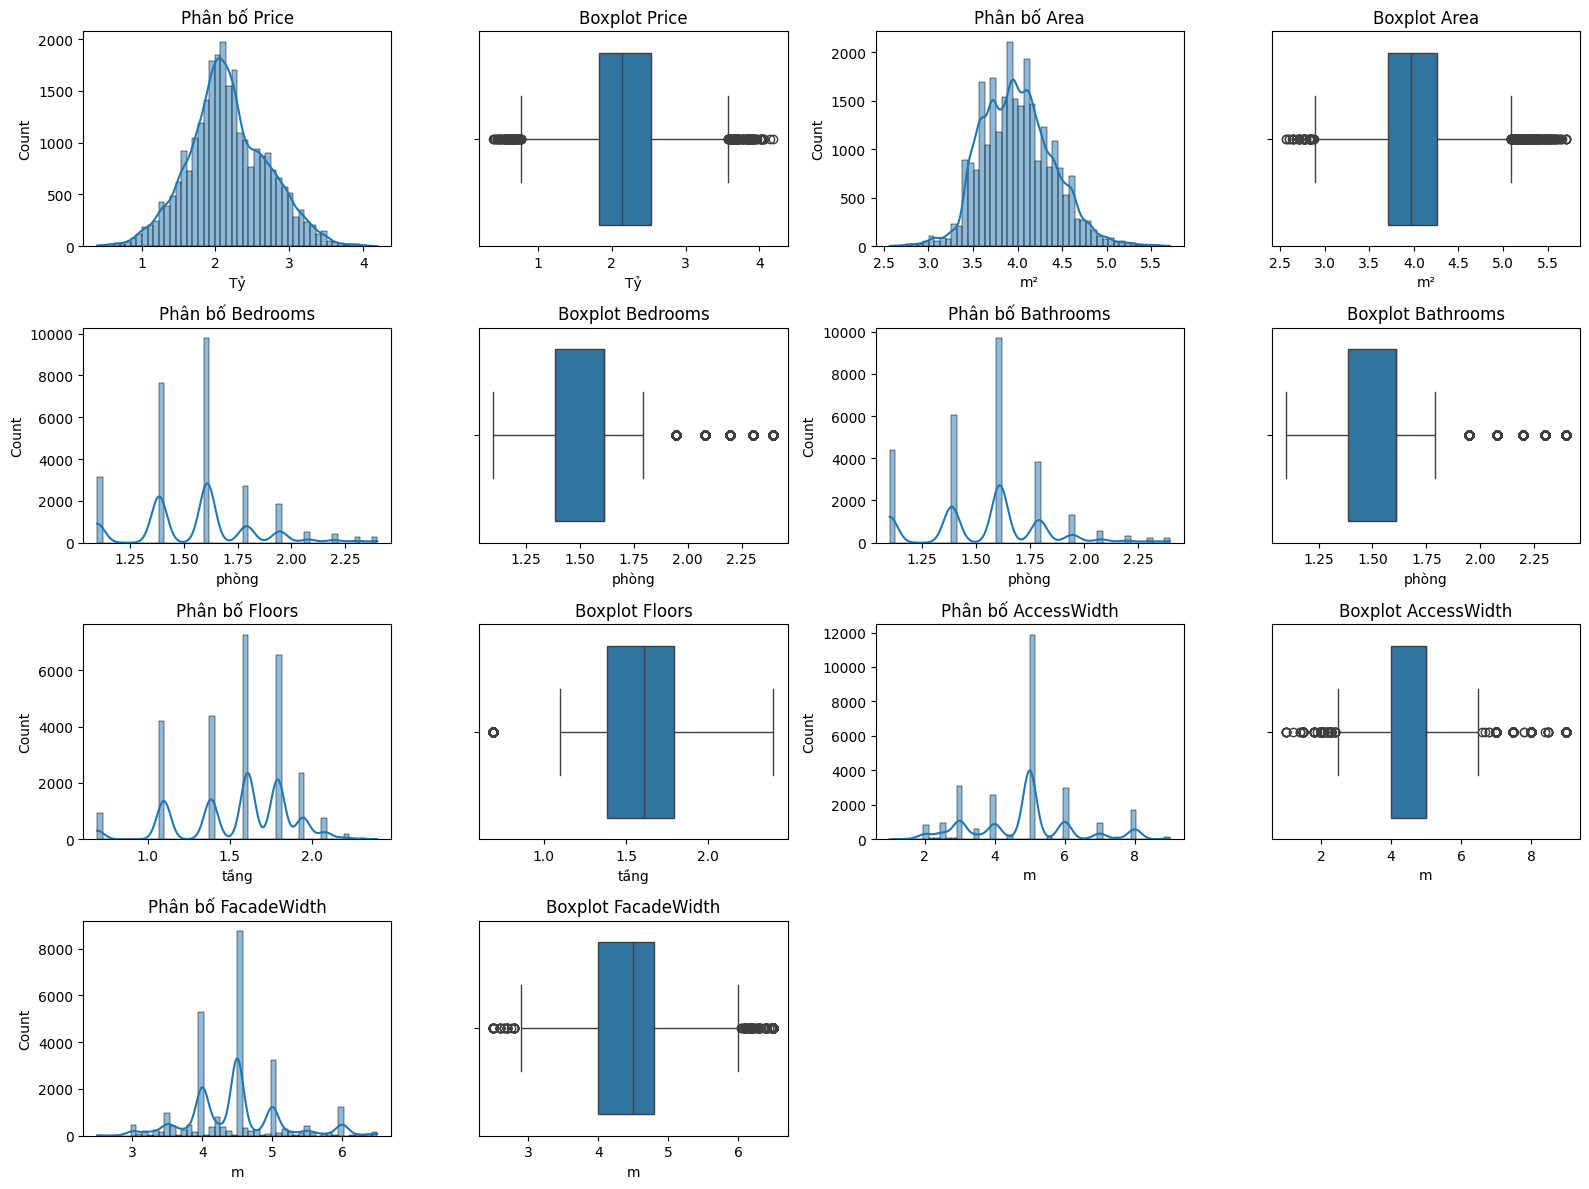

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_hist_box_2cols(df, cols, xlabels):
    n_features = len(cols)
    nrows = (n_features + 1) // 2  # mỗi hàng 2 đặc trưng
    ncols = 4  # 2 đặc trưng * 2 (hist + box)

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12))

    for i, col in enumerate(cols):
        row = i // 2
        col_start = (i % 2) * 2  # 0 hoặc 2

        # Histogram
        sns.histplot(df[col].dropna(), bins=50, kde=True, ax=axes[row, col_start])
        axes[row, col_start].set_title(f'Phân bố {col}')
        axes[row, col_start].set_xlabel(xlabels[i])

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[row, col_start + 1])
        axes[row, col_start + 1].set_title(f'Boxplot {col}')
        axes[row, col_start + 1].set_xlabel(xlabels[i])

    # Ẩn các ô thừa (nếu có)
    total_plots = nrows * ncols
    used_plots = n_features * 2
    for j in range(used_plots, total_plots):
        r = j // ncols
        c = j % ncols
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()

cols = ['Price', 'Area', 'Bedrooms', 'Bathrooms', 'Floors', 'AccessWidth', 'FacadeWidth']
xlabels = ['Tỷ', 'm²', 'phòng', 'phòng', 'tầng', 'm', 'm']

plot_combined_hist_box_2cols(df, cols, xlabels)


In [103]:
# sns.boxplot(data=df, x='Area_Group', y='Price')
# plt.title('Phân bố giá bất động sản theo nhóm diện tích')
# plt.xlabel('Nhóm diện tích')
# plt.ylabel('Giá bất động sản')
# plt.show()


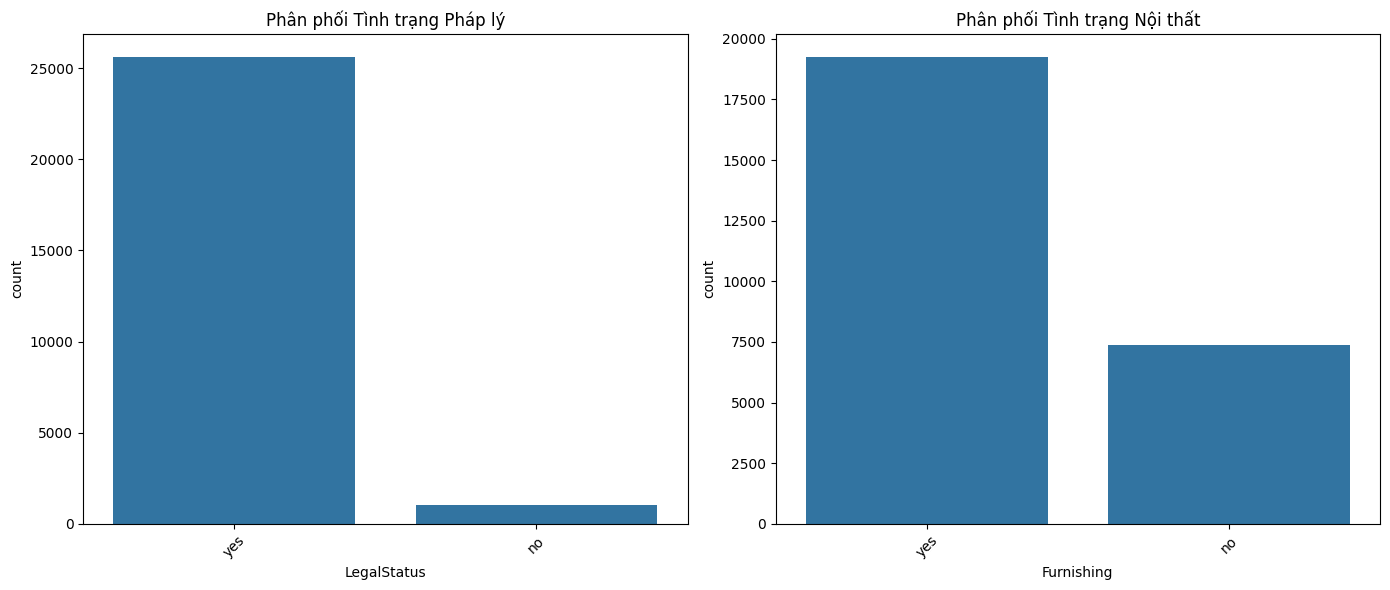

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Biểu đồ phân phối LegalStatus
sns.countplot(data=df, x='LegalStatus', ax=axes[0], order=df['LegalStatus'].value_counts().index)
axes[0].set_title('Phân phối Tình trạng Pháp lý')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ phân phối Furnishing
sns.countplot(data=df, x='Furnishing', ax=axes[1], order=df['Furnishing'].value_counts().index)
axes[1].set_title('Phân phối Tình trạng Nội thất')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## IV. Phân tích tương quan


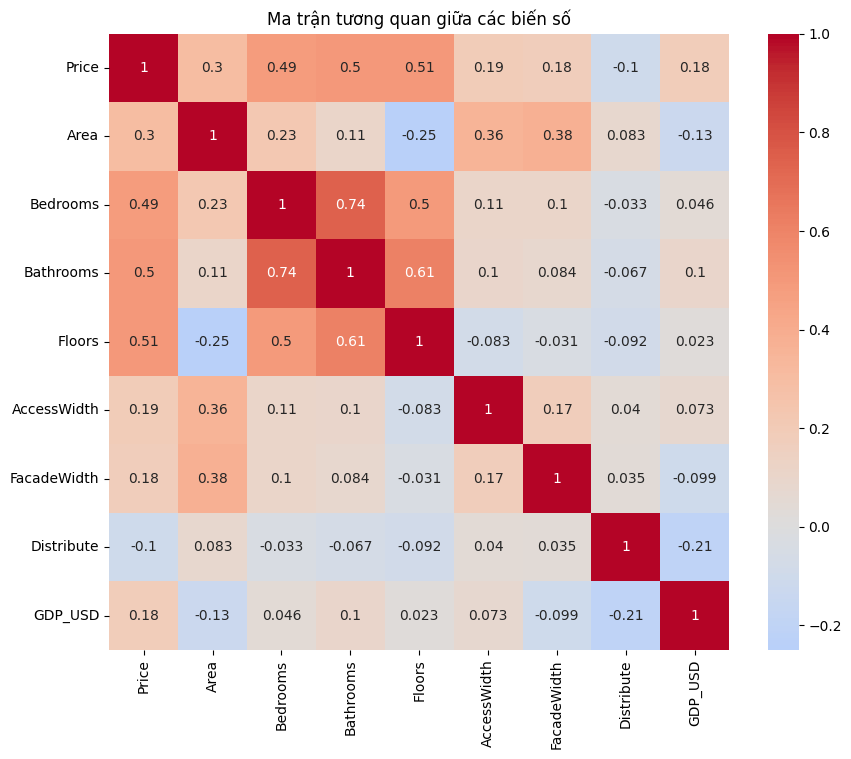

In [105]:
# Tính toán ma trận tương quan
numeric_cols = ['Price', 'Area', 'Bedrooms', 'Bathrooms', 'Floors', 'AccessWidth', 'FacadeWidth', 'Distribute', 'GDP_USD']
correlation_matrix = df[numeric_cols].corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Ma trận tương quan giữa các biến số')
plt.show()

#### Nhận xét

- **Bedrooms** và **Bathrooms** có tương quan gần như tuyệt đối (**0.97**), nên cân nhắc chỉ giữ lại một biến hoặc gộp lại để tránh trùng lặp thông tin.
- **Price** (giá) có tương quan vừa phải với **Area**, **Bedrooms**, **Bathrooms**, **Floors** (khoảng **0.39–0.44**), cho thấy các yếu tố này đều ảnh hưởng đến giá nhưng không phải là yếu tố quyết định duy nhất.
- **AccessWidth** và **FacadeWidth** có tương quan rất thấp với các biến khác, có thể giữ lại để kiểm tra thêm giá trị dự báo.
- **Area** và **Floors** có tương quan âm nhẹ, phù hợp với thực tế nhà diện tích lớn thường ít tầng.

#### Phương hướng xử lý

- **Loại bỏ hoặc gộp** một trong hai biến Bedrooms/Bathrooms để tránh đa cộng tuyến.
- **Giữ lại các biến** Area, Bedrooms/Bathrooms, Floors vì đều có ảnh hưởng đến giá.
- **Tiếp tục kiểm tra** giá trị dự báo của AccessWidth và FacadeWidth trong các mô hình sau.
- **Có thể tạo thêm đặc trưng tổng hợp** (ví dụ: tổng số phòng) để tăng sức mạnh dự báo cho mô hình.


## V. Phân tích theo khu vực địa lý


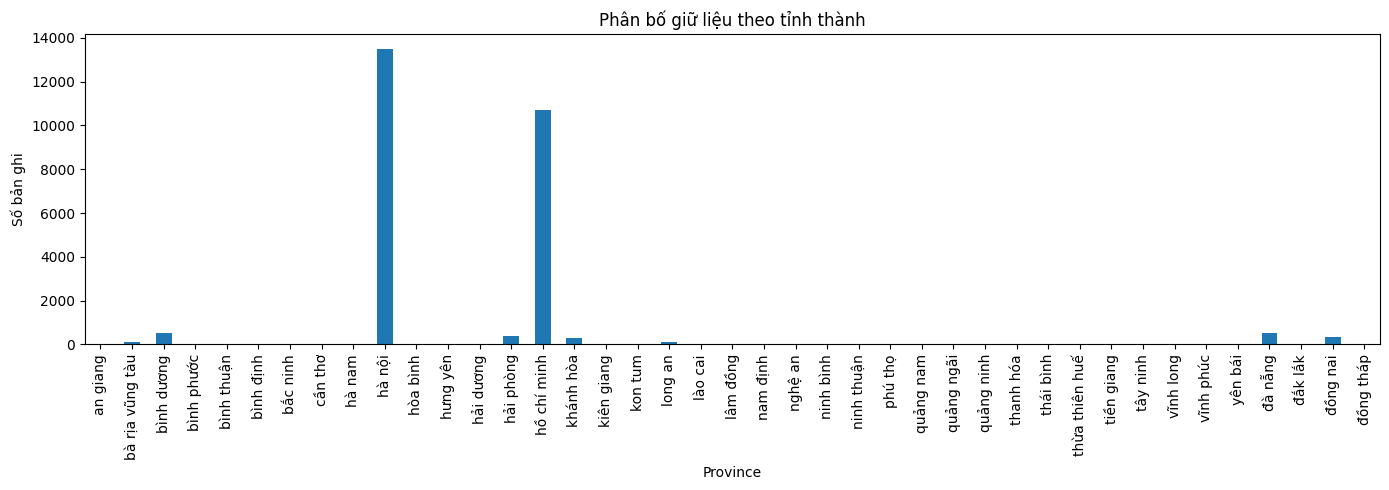

In [106]:
area_counts = df['Province'].value_counts().sort_index()

plt.figure(figsize=(14, 5))
area_counts.plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Số bản ghi')
plt.title('Phân bố giữ liệu theo tỉnh thành')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### Nhận xét

- Dữ liệu phân bố **mất cân đối**, chủ yếu tập trung ở **Hà Nội và TP.HCM**.
- Các tỉnh khác có rất **ít bản ghi**, gây khó khăn cho phân tích toàn diện.
- Mô hình có thể **thiên lệch** nếu không xử lý cân bằng dữ liệu.

#### Phương hướng xử lý:

- **Bổ sung đặc trưng tỉnh/thành** như mật độ dân số, GRDP, mức độ phát triển... để tăng tính đại diện.
